In [1]:
import io
from pathlib import Path

import meshio
import numpy as np
import matplotlib.pyplot as plt

import zarr
import dask as da

from datetime import datetime

```
ply
format ascii 1.0           { ascii/binary, format version number }
comment made by Greg Turk  { comments keyword specified, like all lines }
comment this file is a cube
element vertex 8           { define "vertex" element, 8 of them in file }
property float x           { vertex contains float "x" coordinate }
property float y           { y coordinate is also a vertex property }
property float z           { z coordinate, too }
element face 6             { there are 6 "face" elements in the file }
property list uchar int vertex_index { "vertex_indices" is a list of ints }
end_header                 { delimits the end of the header }
0 0 0                      { start of vertex list }
0 0 1
0 1 1
0 1 0
1 0 0
1 0 1
1 1 1
1 1 0
4 0 1 2 3                  { start of face list }
4 7 6 5 4
4 0 4 5 1
4 1 5 6 2
4 2 6 7 3
4 3 7 4 0
```

NameError: name 'mesh' is not defined

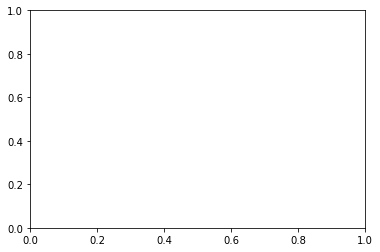

In [4]:
fig, ax = plt.subplots()

lines = ax.plot(*mesh.points[mesh.cells_dict['line'], :2].T, 'k');


In [4]:
ply_header = {
    "format": "ascii 1.0",
    "comments": [f"created by ply_zarr v0.0.1, {datetime.now().isoformat()}",],
    "elements": {
        "vertex": {
            "size": 47,
            "properties": [
                ("double", "x"),
                ("double", "y"),
                ("double", "z")
            ]
        },    
        "face": {
            "size": 105,
            "properties": [
                ("list", "uint8", "int32", "vertex_indices"),
            ]
        }
    }
}


In [5]:
def parse_ply_header(fh):
    """
    fh: file handle on a ply file
    """
    fh.seek(0)
    attrs = {}
    attrs['format'] = ""
    attrs['comments'] = []
    attrs['elements'] = {}
    last_elem = None
    if not fh.readline().decode("utf-8").startswith('ply'):
        raise IOError("Not a ply file")
    for line in fh:
        line = line.decode("utf-8")
        start, *rest = line.split()
        if start == 'format':
            attrs['format'] = " ".join(rest)

        elif start == "comment":
            attrs['comments'].append(" ".join(rest))

        elif start == "element":
            elem = rest[0]
            attrs['elements'][elem] = {
                "size": int(rest[1]),
                "properties": []
            }
            last_elem = elem

        elif start == "property":
            attrs['elements'][elem]["properties"].append(tuple(rest))

        elif start == "end_header":
            break
    
    return attrs

In [6]:
with open("test.ply", "rb") as fh:
    attrs = parse_ply_header(fh)

In [7]:
attrs

{'format': 'ascii 1.0',
 'comments': ['Created by meshio v4.3.8, 2021-02-24T11:44:59.848778'],
 'elements': {'vertex': {'size': 47,
   'properties': [('double', 'x'), ('double', 'y'), ('double', 'z')]},
  'face': {'size': 105,
   'properties': [('list', 'uint8', 'int32', 'vertex_indices')]}}}

In [8]:
def attrs_to_ply_header(attrs):
    lines = []
    lines.append("ply")
    lines.append('format '+attrs["format"])
    
    if attrs.get("comments"):
        lines.extend(['comment ' + c for c in attrs["comments"]])
    for elem, elem_dict in attrs["elements"].items():
        lines.append(f"element {elem} {elem_dict['size']}")
        for prop in elem_dict["properties"]:
            lines.append("property "+" ".join(prop))
    lines.append("end_header\n")
    return "\n".join(lines)

In [9]:
from meshio.ply._ply import cell_type_to_count, numpy_to_ply_dtype

def header_from_mesh(mesh, fh, binary=False):
    """Shamelessly stolen from meshio
    
    https://github.com/nschloe/meshio/blob/0600ac9e9e8d1e1a27d5f3f2f4235414f4482cac/meshio/ply/_ply.py#L392
    
    
    
    """
    # TODO: what to do with binary?

    fh.write(b"ply\n")

    if binary:
        fh.write(f"format binary_{sys.byteorder}_endian 1.0\n".encode("utf-8"))
    else:
        fh.write(b"format ascii 1.0\n")

    fh.write(
        "comment Created by ply-zarr v0.0.1, {}\n".format(
            datetime.now().isoformat()
        ).encode("utf-8")
    )

    # counts
    fh.write("element vertex {:d}\n".format(mesh.points.shape[0]).encode("utf-8"))
    #
    dim_names = ["x", "y", "z"]
    # From <https://en.wikipedia.org/wiki/PLY_(file_format)>:
    #
    # > The type can be specified with one of char uchar short ushort int uint float
    # > double, or one of int8 uint8 int16 uint16 int32 uint32 float32 float64.
    #
    # We're adding [u]int64 here.
    type_name_table = {
        np.dtype(np.int8): "int8",
        np.dtype(np.int16): "int16",
        np.dtype(np.int32): "int32",
        np.dtype(np.int64): "int64",
        np.dtype(np.uint8): "uint8",
        np.dtype(np.uint16): "uint16",
        np.dtype(np.uint32): "uint32",
        np.dtype(np.uint64): "uint64",
        np.dtype(np.float32): "float",
        np.dtype(np.float64): "double",
    }
    for k in range(mesh.points.shape[1]):
        type_name = type_name_table[mesh.points.dtype]
        fh.write("property {} {}\n".format(type_name, dim_names[k]).encode("utf-8"))

    pd = []
    for key, value in mesh.point_data.items():
        if len(value.shape) > 1:
            warnings.warn(
                "PLY writer doesn't support multidimensional point data yet. Skipping {}.".format(
                    key
                )
            )
            continue
        type_name = type_name_table[value.dtype]
        fh.write(f"property {type_name} {key}\n".encode("utf-8"))
        pd.append(value)

    num_cells = 0
    for cell_type, c in mesh.cells:
        if cell_type_to_count(cell_type):
            num_cells += c.data.shape[0]
    if num_cells > 0:
        fh.write(f"element face {num_cells:d}\n".encode("utf-8"))

        # possibly cast down to int32
        has_cast = False
        for k, (cell_type, data) in enumerate(mesh.cells):
            if data.dtype == np.int64:
                has_cast = True
                mesh.cells[k] = CellBlock(cell_type, data.astype(np.int32))

        if has_cast:
            warnings.warn(
                "PLY doesn't support 64-bit integers. Casting down to 32-bit."
            )

        # assert that all cell dtypes are equal
        cell_dtype = None
        for _, cell in mesh.cells:
            if cell_dtype is None:
                cell_dtype = cell.dtype
            if cell.dtype != cell_dtype:
                raise WriteError()

        if cell_dtype is not None:
            ply_type = numpy_to_ply_dtype[cell_dtype]
            fh.write(
                "property list {} {} vertex_indices\n".format(
                    "uint8", ply_type
                ).encode("utf-8")
            )

    # TODO other cell data
    fh.write(b"end_header\n")


In [10]:
print(attrs_to_ply_header(attrs))

ply
format ascii 1.0
comment Created by meshio v4.3.8, 2021-02-24T11:44:59.848778
element vertex 47
property double x
property double y
property double z
element face 105
property list uint8 int32 vertex_indices
end_header



In [11]:
with open("test.ply", "r") as fh:
    content = fh.readlines()

In [12]:
header = "".join(content[:10])

header == attrs_to_ply_header(attrs)

True

In [14]:
from pprint import pprint

def write_plyzarr(group, mesh):
    
    
    # PLY header to mesh
    fh = io.BytesIO()
    header_from_mesh(mesh, fh, binary=False)
    group.attrs.update(parse_ply_header(fh))

    group["points"] = mesh.points
    for elem, verts in mesh.cells_dict.items():
        cnt = cell_type_to_count(elem)
        group[cnt] = verts

root = zarr.group()
write_plyzarr(root, mesh)
print(root.tree())
pprint(root.attrs.asdict())

/
 ├── 2 (90, 2) int32
 ├── 5 (2, 5) int32
 ├── 6 (12, 6) int32
 ├── 8 (1, 8) int32
 └── points (47, 3) float64
{'comments': ['Created by ply-zarr v0.0.1, 2021-02-24T17:15:21.819314'],
 'elements': {'face': {'properties': [('list',
                                       'uint8',
                                       'int32',
                                       'vertex_indices')],
                       'size': 105},
              'vertex': {'properties': [('double', 'x'),
                                        ('double', 'y'),
                                        ('double', 'z')],
                         'size': 47}},
 'format': 'ascii 1.0'}


In [15]:
def plyzarr_to_ply(group, fh):
    attrs = group.attrs.asdict()
    header = attrs_to_ply_header(attrs)
    fh.write(header.encode("utf-8"))
    points = group.points
    fh.seek(0, 2)
    np.savetxt(fh, points, fmt="%.18f")
    polys = [k for k in group.array_keys() if k != "points"]
    polys.sort()
    print(polys)
    for p in polys:
        sizes = int(p) * np.ones((group[p].shape[0], 1))
        vertices = np.concatenate([sizes, group[p]], axis=1)
        np.savetxt(fh, vertices, fmt="%d")
        fh.seek(0, 2)

In [ ]:
%pdb

In [16]:
with open("test_out.ply", "wb") as fh:
    plyzarr_to_ply(root, fh)
    

['2', '5', '6', '8']


In [19]:
mesh_r = meshio.read("test_out.ply")

In [22]:
mesh_r == mesh

False

In [23]:
mesh

<meshio mesh object>
  Number of points: 47
  Number of cells:
    line: 90
    polygon5: 2
    polygon6: 12
    polygon8: 1